#Importing Libraries:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import time
import matplotlib.pyplot as plt
%matplotlib inline

#Transforming Data:

In [2]:
#Converting MNIST images into 4D tensors [no. of images, height, width, color channel]

transform = transforms.ToTensor()

In [3]:
#Import Train Data

train_data = datasets.MNIST(root='./MNIST_CNN_DATA', train=True, download=True, transform=transform) #downloads MNIST training dataset in root path

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./MNIST_CNN_DATA/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_CNN_DATA/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]


Extracting ./MNIST_CNN_DATA/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_CNN_DATA/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting ./MNIST_CNN_DATA/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_CNN_DATA/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.67MB/s]

Extracting ./MNIST_CNN_DATA/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_CNN_DATA/MNIST/raw



In [4]:
#Import Test Data

test_data = datasets.MNIST(root='./MNIST_CNN_DATA', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./MNIST_CNN_DATA
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./MNIST_CNN_DATA
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
#Data Loaders:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

#CNN Model:

In [8]:
#2 Convolutional Layers
conv1 = nn.Conv2d(1, 6, 3, 1) #1 inputs, 6 outputs, 3*3 kernel size, 1 stride
conv2 = nn.Conv2d(6, 16, 3, 1)

In [9]:
#take one mnist image

for i, (X_train, y_train) in enumerate(train_loader):
  break

print(X_train.shape)
print(y_train.shape)

torch.Size([10, 1, 28, 28])
torch.Size([10])


In [10]:
#reshape tensor to 4D
x = X_train[0].view(1, 1, 28, 28)

x.shape

torch.Size([1, 1, 28, 28])

In [11]:
#Apply 1st convolution layer
x = F.relu(conv1(x))

x.shape

#[no. of images, filters/outputs, image height, image width]

torch.Size([1, 6, 26, 26])

In [12]:
#Apply pooling layer

x = F.max_pool2d(x, 2, 2,) #kernel size 2, stride size 2

#image size (26) gets divided by 2 = 13

x.shape

#[no. of images, filters/outputs, image height, image width]

torch.Size([1, 6, 13, 13])

In [13]:
#Apply 2nd Convolutional Layer

x = F.relu(conv2(x))

x.shape

torch.Size([1, 16, 11, 11])

In [14]:
#Apply Pooling Layer

x = F.max_pool2d(x,2,2)

x.shape

torch.Size([1, 16, 5, 5])

In [15]:
#Model Class:
class CNN(nn.Module):

  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)

    #Fully Connected Layers:
    self.fc1 = nn.Linear(5*5*16, 120) #the shape obtained after applying all conv and pooling layers is [1, 16, 5, 5] and 120 is the no. of neurons
    self.fc2 = nn.Linear(120, 85)
    self.fc3 = nn.Linear(85, 10) #10 outputs = 0-9 digits

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2) #2*2 kernel, stride 2
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    #Flattening:
    X = X.view(-1, 5*5*16)

    #Applying Fully connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return X

In [16]:
#Model instance

torch.manual_seed(101)

model = CNN()

model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=85, bias=True)
  (fc3): Linear(in_features=85, out_features=10, bias=True)
)

#Set up Loss & Optimizer:

In [17]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Training:

In [18]:
#Training:

epochs = 3
train_losses = []
train_correct = []
start_time = time.time()

for epoch in range(epochs):
  trn_corr = 0

  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 #Start batches at 1

    y_pred = model(X_train) #predicting values from training set

    loss = criterion(y_pred, y_train) #calculating loss

    predicted = torch.max(y_pred.data, 1)[1]
    #torch.max returns max value = [value, index]
    #storing indexes i.e. [1] in predicted

    batch_corr = (predicted == y_train).sum() #calculates the total no. of correct predictions

    trn_corr += batch_corr

    #update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%600 == 0:
      print(f'Epoch: {epoch+1} / {epochs}, Batch: {b}, Loss: {loss.item():.4f}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


current_time = time.time()

total_time = current_time - start_time

print(f'Total Training Time: {total_time/60:.4f} minutes')

Epoch: 1 / 3, Batch: 600, Loss: 0.0876
Epoch: 1 / 3, Batch: 1200, Loss: 0.1357
Epoch: 1 / 3, Batch: 1800, Loss: 0.3918
Epoch: 1 / 3, Batch: 2400, Loss: 0.0178
Epoch: 1 / 3, Batch: 3000, Loss: 0.0917
Epoch: 1 / 3, Batch: 3600, Loss: 1.0760
Epoch: 1 / 3, Batch: 4200, Loss: 0.0936
Epoch: 1 / 3, Batch: 4800, Loss: 0.2011
Epoch: 1 / 3, Batch: 5400, Loss: 0.0146
Epoch: 1 / 3, Batch: 6000, Loss: 0.0165
Epoch: 2 / 3, Batch: 600, Loss: 0.0273
Epoch: 2 / 3, Batch: 1200, Loss: 0.0278
Epoch: 2 / 3, Batch: 1800, Loss: 0.0898
Epoch: 2 / 3, Batch: 2400, Loss: 0.0586
Epoch: 2 / 3, Batch: 3000, Loss: 0.0226
Epoch: 2 / 3, Batch: 3600, Loss: 0.0881
Epoch: 2 / 3, Batch: 4200, Loss: 0.4787
Epoch: 2 / 3, Batch: 4800, Loss: 0.0023
Epoch: 2 / 3, Batch: 5400, Loss: 0.0003
Epoch: 2 / 3, Batch: 6000, Loss: 0.0198
Epoch: 3 / 3, Batch: 600, Loss: 0.0055
Epoch: 3 / 3, Batch: 1200, Loss: 0.0022
Epoch: 3 / 3, Batch: 1800, Loss: 0.0008
Epoch: 3 / 3, Batch: 2400, Loss: 0.0416
Epoch: 3 / 3, Batch: 3000, Loss: 0.0022
Epo

#Testing:

In [19]:
#Testing:
with torch.no_grad():
  tst_corr = 0
  for b, (X_test, y_test) in enumerate(test_loader):
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    tst_corr += (predicted == y_test).sum()

In [20]:
test_acc = tst_corr.item()/len(test_data)
print(f'accuracy: {test_acc:.4f}')

accuracy: 0.9796


#Plotting:

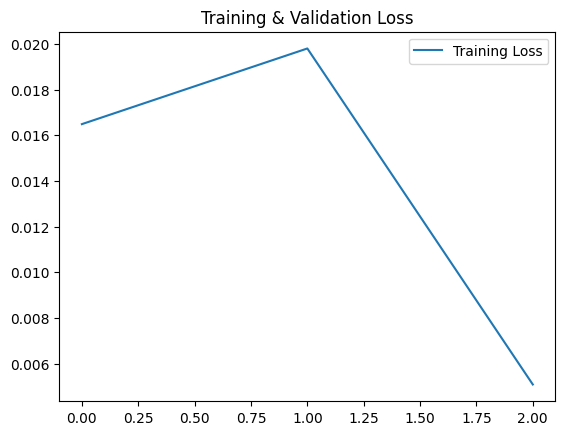

In [21]:
train_losses = [t.item() for t in train_losses]
plt.plot(train_losses, label='Training Loss')
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

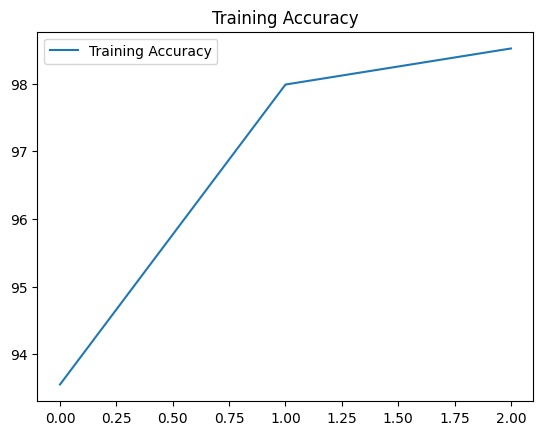

In [22]:
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.title("Training Accuracy")
plt.legend()
plt.show

#Save & Load Model:

In [23]:
# Save model's parameters
torch.save(model.state_dict(), 'MNIST_CNN_Parameters.pt')

In [24]:
# Load model's parameters
model = CNN() # create an instance of model
model.load_state_dict(torch.load('MNIST_CNN_Parameters.pt'))
model.eval()

<ipython-input-24-2eae81d85482>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('MNIST_CNN_Parameters.pt'))


CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=85, bias=True)
  (fc3): Linear(in_features=85, out_features=10, bias=True)
)

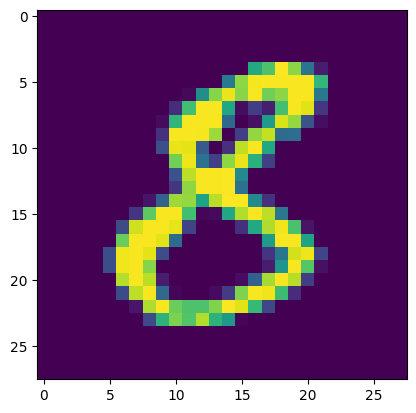

In [25]:
#Test Manually
img_num = 1234
plt.imshow(test_data[img_num][0].reshape(28,28)) #taking a random test record (only x features) and reshaping the tensor

In [26]:
with torch.no_grad():
  pred = model(test_data[img_num][0].view(1, 1, 28, 28)) #batch size 1, color channel 1, img size 28*28
  print(f'Predicted Digit: {torch.argmax(pred)}')

Predicted Digit: 8
